In [1]:
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Часть первая: крестики-нолики при помощи Q-обучения

In [2]:
class TicTacToe:
    def __init__(self, p1, p2, board_rows, board_cols, num_counts):
        self.board = np.zeros((board_rows, board_cols), dtype = int)
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.playerSymbol = 1
        self.board_rows = board_rows
        self.board_cols = board_cols
        self.num_counts = num_counts
        
    def getHash(self):
        return self.board.tobytes()

    def winner(self):
        for i in range(self.board_rows):
            if sum(self.board[i, :]) == self.num_counts:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -self.num_counts:
                self.isEnd = True
                return -1
        
        for i in range(self.board_cols):
            if sum(self.board[:, i]) == self.num_counts:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -self.num_counts:
                self.isEnd = True
                return -1

        diag_sum1 = sum([self.board[i, i] for i in range(self.board_cols)])
        diag_sum2 = sum([self.board[i, self.board_cols - i - 1] for i in range(self.board_cols)])
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        
        if diag_sum == self.num_counts:
            self.isEnd = True
            if diag_sum1 == self.num_counts or diag_sum2 == self.num_counts:
                return 1
            else:
                return -1
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        self.isEnd = False
        return None

    def availablePositions(self):
        positions = []
        for i in range(self.board_rows):
            for j in range(self.board_cols):
                if self.board[i, j] == 0:
                    positions.append((i, j))
        return positions

    def updateState(self, position):
        self.board[position] = self.playerSymbol
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1

    def giveReward(self):
        result = self.winner()
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(-1)
        elif result == -1:
            self.p1.feedReward(-1)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0)
            self.p2.feedReward(0)

    def reset(self):
        self.board = np.zeros((self.board_rows, self.board_cols), dtype = int)
        self.isEnd = False
        self.playerSymbol = 1

    def fit(self, rounds, delta_i_valid, n_test, set_change_expl, is_change_expl):       
        self._fig, self._ax = plt.subplots(figsize=(8, 6))
        dict_data = {-1: [], 0: [], 1: []}
        mean_data = []
        data_x = []
        
        for i in tqdm(range(rounds)):
            self.reset()
            if i % delta_i_valid == 0:
                counts = 0
                dict_res = {-1: 0,
                            0: 0,
                            1: 0,
                           }
                for j in range(n_test):
                    res = self.play_one_game(set_change_expl=set_change_expl, 
                                                 is_change_expl=is_change_expl)
                    dict_res[res] += 1
                    counts += res
                data_x.append(i)
                mean_data.append(counts/n_test)
                dict_data[1].append(dict_res[1] / n_test)
                dict_data[0].append(dict_res[0] / n_test)
                dict_data[-1].append(dict_res[-1] / n_test)
                self._draw_plot(rounds, data_x, mean_data, dict_data[1], dict_data[0], dict_data[-1])

            while not self.isEnd:
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                win = self.winner()
                if win is not None:
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break
                else:
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)
                    win = self.winner()
                    if win is not None:
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break

    def play_one_game(self, set_change_expl=(0, 1), is_change_expl=(False, False)):
        self.reset()
        if is_change_expl[0]:
            p1_expl = self.p1.get_exp_rate()
            self.p1.set_exp_rate(set_change_expl[0])
        if is_change_expl[1]:
            p2_expl = self.p2.get_exp_rate()
            self.p2.set_exp_rate(set_change_expl[1])
        
        while not self.isEnd:
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            self.updateState(p1_action)
            win = self.winner()
            if win is not None:
                rew_ = win
                break
            positions = self.availablePositions()
            p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
            self.updateState(p2_action)
            win = self.winner()
            if win is not None:
                rew_ = win
                break   
        
        if is_change_expl[0]:
            self.p1.set_exp_rate(p1_expl)
        if is_change_expl[1]:
            self.p2.set_exp_rate(p2_expl)
        
        return rew_
    
    def _draw_plot(self, rounds, data_x, data_y, data_y1, data_y2, data_y3):
        self._ax.clear()
        self._ax.plot(data_x, data_y1, 'go-', label='Доля побед')
        self._ax.plot(data_x, data_y2, 'b^--', label='Доля ничьих')
        self._ax.plot(data_x, data_y3, 'rs-.', label='Доля поражений')
        self._ax.set_title('Исходы игры',
                           fontdict={'fontsize': 12},
                          )
        self._ax.set_ylabel('Доля побед, ничьих, поражений',
                            fontdict={'fontsize': 10},
                           )
        self._ax.set_xlabel('Итерации обучения',
                            fontdict={'fontsize': 10},
                           )
        self._ax.legend(loc='best')
        self._ax.set_xlim([0, rounds])
        self._ax.set_ylim([0, 1.0])
        self._fig.canvas.draw()

In [3]:
class Player:
    def __init__(self, name, board_cols, board_rows, exp_rate, lr, decay_gamma):
        self.name = name
        self.states = []
        self.lr = lr
        self.exp_rate = exp_rate
        self.decay_gamma = decay_gamma
        self.states_value = {}
        self.board_cols = board_cols
        self.board_rows = board_rows
        
    def getHash(self, board):
        return board.tobytes()
    
    def get_exp_rate(self):
        return self.exp_rate
    
    def set_exp_rate(self, exp_rate):
        self.exp_rate = exp_rate

    def chooseAction(self, positions, current_board, symbol):
        if random.random() <= self.exp_rate:
            idx = random.choice(range(len(positions)))
            action = positions[idx]
        else:
            value_max = -999
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = random.random() if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                if value >= value_max:
                    value_max = value
                    action = p
        return action
    
    def addState(self, state):
        self.states.append(state)
        
    def feedReward(self, reward):
        for st in self.states[::-1]:
            if self.states_value.get(st) is None:
                self.states_value[st] = random.random()
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]
            
    def reset(self):
        self.states = []

    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()

## Крестики-нолики 3x3

<IPython.core.display.Javascript object>


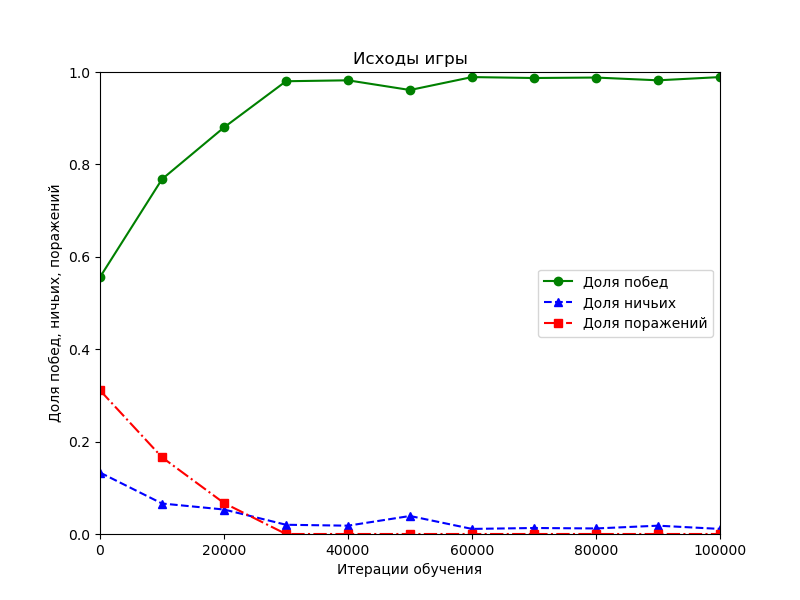

In [4]:
%matplotlib notebook

# Размер доски
board_cols, board_rows, num_counts = 3, 3, 3 

# Игроки
player_1 = Player('p1',
                  board_cols,
                  board_rows,
                  exp_rate=0.3,
                  lr=0.05,
                  decay_gamma=0.8,
                 )
player_2 = Player('p2',
                  board_cols,
                  board_rows,
                  exp_rate=0.3,
                  lr=0.05,
                  decay_gamma=0.8,
                 )

# Игра
game = TicTacToe(player_1,
                 player_2,
                 board_cols,
                 board_rows,
                 num_counts,
                )

game.fit(rounds=int(1e5+1),
         delta_i_valid=int(1e4),
         n_test=int(1e3),
         set_change_expl=(0, 1),
         is_change_expl=(True, True),
        )

## Крестики-нолики 4х4 

<IPython.core.display.Javascript object>


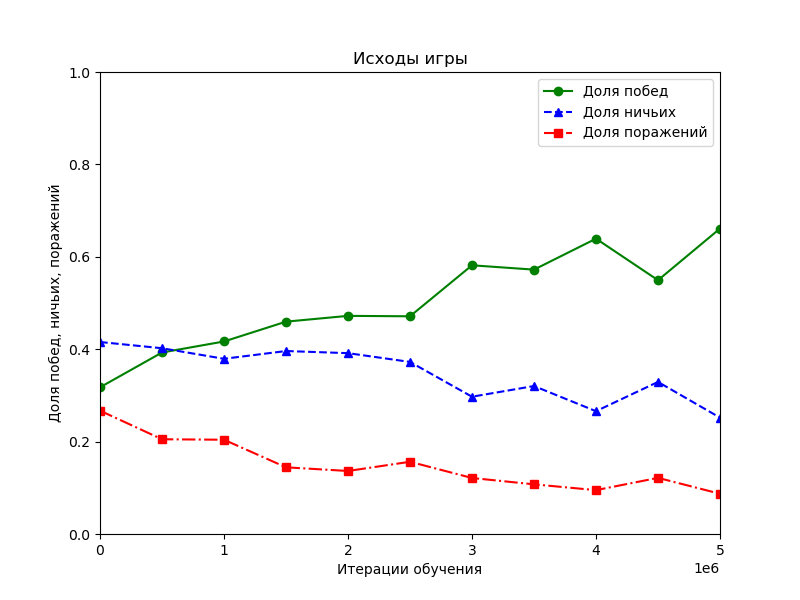

In [5]:
%matplotlib notebook

# Размер доски
board_cols, board_rows, num_counts = 4, 4, 4 

# Игроки
player_1 = Player('p1',
                  board_cols,
                  board_rows,
                  exp_rate=0.3, 
                  lr=0.05,
                  decay_gamma=0.8,
                 )
player_2 = Player("p2",
                  board_cols,
                  board_rows,
                  exp_rate=0.3,
                  lr=0.05,
                  decay_gamma=0.8,
                 )

# Игра
game = TicTacToe(player_1,
                 player_2,
                 board_cols,
                 board_rows,
                 num_counts,
                )

game.fit(rounds=int(5e6+1),
         delta_i_valid=int(5e5),
         n_test=int(5e4),
         set_change_expl=(0, 1),
         is_change_expl=(True, True),
        )